# The Future of Basketball Players

## Set up Environment

In [1]:
!python -c "import pandas as pd; print(pd.__version__)"

1.2.0


In [2]:
!pip show scipy

Name: scipy
Version: 1.6.0
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: c:\users\david anker\.virtualenvs\mdsi_adsi_feb21_at1-n_gyw-cp\lib\site-packages
Requires: numpy
Required-by: seaborn, scikit-learn, phik, pandas-profiling, missingno, imbalanced-learn, ImageHash


In [3]:
# Import modules
import os
import sys
import zipfile
import sklearn
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from pprint import pprint
from pandas_profiling import ProfileReport
from IPython.display import IFrame
import random

In [4]:
# If not running in Jypyter, change the cwd to correct dir
if not "Interactive" in get_ipython().__class__.__name__:
    os.chdir("./notebooks/Chris")

# Set up environment
if not os.path.abspath("../..") in sys.path:
    sys.path.append(os.path.abspath("../.."))
else:
    sys.path.remove(os.path.abspath("../.."))
    sys.path.append(os.path.abspath("../.."))

### Custom Global Functions

In [5]:
def str_right(string:str, num_chars:int):
    """ Sub-Select the right-most number of characters from a string """
    assert isinstance(string, str)
    assert isinstance(num_chars, int)
    return string[-num_chars:]

def get_list_proportions(lst:list):
    assert isinstance(lst, (list, np.ndarray))
    prop = {}
    dist = list(set(lst))
    for val in dist:
        prop[val] = sum(map(lambda x: x==val, lst))/len(lst)
    return prop

## Get Data

In [6]:
# Check & Create directories
for dir in ["../../data/processed/Chris", "../../models/Chris"]:
    if not os.path.exists(dir): os.mkdir(dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../data/processed/Chris'

In [7]:
# Use bash to get data from kaggle
!kaggle competitions files -c uts-advdsi-nba-career-prediction
!kaggle competitions download -c uts-advdsi-nba-career-prediction --path ../../data/raw --force --quiet

# Unzip the data
with zipfile.ZipFile("../../data/raw/uts-advdsi-nba-career-prediction.zip", "r") as z:
    z.extractall("../../data/raw")


# Delete the zip file
if os.path.exists("../../data/raw/uts-advdsi-nba-career-prediction.zip"):
    os.remove("../../data/raw/uts-advdsi-nba-career-prediction.zip")

name                    size  creationDate         
---------------------  -----  -------------------  
test.csv               323KB  2021-01-30 23:13:35  
train.csv              701KB  2021-01-30 23:13:35  
sample_submission.csv   40KB  2021-01-30 23:13:35  


In [7]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
data = pd.read_csv("../../data/raw/train.csv")

# Check data
# print(data.columns)
display(data)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P_Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [8]:
# Fix column names
print(data.columns)
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Save training data again
data.to_csv("../../data/raw/train.csv", index=False)

# Apply same logix to test data
test = pd.read_csv("../../data/raw/test.csv")
test.columns = test.columns.str.replace(' ', '_')
test.to_csv("../../data/raw/test.csv", index=False)

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')
Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')


## Check Data

### Data Dictionary

In [9]:
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

### Data Exploration

In [10]:
# Prevent the need to re-run
if os.path.exists("InitialReport.html"):
    IFrame(src="InitialReport.html", width="100%", height=600)
else:
    # Create profile report
    profile = ProfileReport(data, title="Profile Report")
    # Export
    profile.to_file("InitialReport.html")
    # View
    profile

## Experimentation

### Data Manipulation

Steps:

1. Drop the `ID` column
1. Pop the `target` column
1. Scale the features
1. Split in to train/test

In [11]:
# Drop ID
data = data.drop(['Id'], axis=1)

# Pop targ
feat = data.iloc[:,:-1].to_numpy()
targ = data.iloc[:,-1].to_numpy()

# Scale feat
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

# Tran/Test split
from sklearn.model_selection import train_test_split
feat_trn, feat_val, targ_trn, targ_val = train_test_split(feat, targ, test_size=0.3, random_state=6)

In [12]:
# Dump your objects
dump(data, "../../data/processed/Chris/data.joblib")
dump(feat, "../../data/processed/Chris/feat.joblib")
dump(targ, "../../data/processed/Chris/targ.joblib")
dump(feat_trn, "../../data/processed/Chris/feat_trn.joblib")
dump(feat_val, "../../data/processed/Chris/feat_val.joblib")
dump(targ_trn, "../../data/processed/Chris/targ_trn.joblib")
dump(targ_val, "../../data/processed/Chris/targ_val.joblib")
dump(scaler, "../../models/Chris/scaler.joblib")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/Chris/data.joblib'

### Set up Experiment Space

In [13]:
# Set DF for score dumps
pred_scor = pd.DataFrame(
    { "name": []
    , "when": []
    , "auc": []
    , "sens": []
    , "spec": []
    , "f1": []
    }
)

In [23]:
def plot_roc_curve(pred:np.real, targ:np.real):
    

    # Imports
    import numpy as np
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    # Assertions
    assert np.all(np.isreal(pred))
    assert np.all(np.isreal(targ))

    # Generate data
    fpr, tpr, thresholds = roc_curve(targ, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Generate plot
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC (AUC={:.3f}".format(roc_auc))
    plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics")
    plt.legend(loc="lower right")
    plt.show

    # Return
    return None

def save_reg_perf \
    ( pred:np.real
    , targ:np.real
    , name:str=None
    , df_metrics:pd.DataFrame=None
    , overwrite:bool=True
    , print:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):
    """
    Save model metrics to a dataframe.

    Args:
        pred (np.real): The prediction values. Can be scalar or array, but must be Real numbers.
        targ (np.real): The actual values. Can be scalar or arrya, but must be Real numbers.
        name (str, optional): The name of the data being calculated. If not given, will default to 'None'. Defaults to None.
        df_metrics (pd.DataFrame, optional): The data frame to be updated to contain the data. If not given, will update the `pred_scor` dataframe from the global scope. Defaults to None.
        overwrite (bool, optional): Whether or not to overwrite the data in the dataframe. In SQL-speak: True=UPDATE, False=INSERT. Defaults to True.
        print (bool, optional): Wheather or not to turn off all printing. Defaults to True.
        print_matrix (bool, optional): Whether or not to print the confusion matrix. Defaults to True.
        print_plot (bool, optional): Whether or not to print the ROC plot. Defaults to True.
        print_dataframe (bool, optional): Whether or not to print the final updated dataframe. Defaults to True.

    Raises:
        Assertions: Each parameter will be asserted to the proper type and attribute.

    Returns:
        pd.DataFrame: The updated dataframe.
    """    
    
    # Imports
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix as conf
    from sklearn.metrics import roc_auc_score as auc
    from sklearn.metrics import f1_score as f1

    # Assertions
    assert np.all(np.isreal(pred))
    assert np.all(np.isreal(targ))
    for parameter in [overwrite, print_matrix, print_plot, print_dataframe]:
        assert isinstance(parameter, bool)
    if not name==None:
        assert np.isscalar(name)
        assert isinstance(name, str)
    if not df_metrics==None:
        assert isinstance(df_metrics, pd.DataFrame)
        assert df_metrics.columns == ["name","when","auc","sens","spec","f1"]

    # Ensure we're using the global object here
    global pred_scor

    # If you want to use another dataframe, go right ahead. Else, just keep it simple.
    if df_metrics==None: df = pred_scor
    else: df = df_metrics
    
    # Best to define name, but if blank then make None
    if name==None: name=="None"

    # Perform calculations
    val_now = pd.Timestamp.now().strftime('%d/%b %H:%M')
    tn, fp, fn, tp = conf(targ,pred).ravel()
    val_auc = round(auc(targ,pred), 5)
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(targ,pred), 5)

    # Two different methods of updating the table. In SQL-Speak this is the difference between INSERT and UPDATE
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["when"]] = val_now
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "when": [val_now]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        df = df.append(new)

    # Fix Pandas indexes
    df.reset_index(drop=True, inplace=True)

    # Assign back to the global scope
    pred_scor = df

    # Print if needed
    if print:
        if print_matrix:
            display(pd.DataFrame(conf(targ,pred), columns=pd.MultiIndex.from_tuples([("targ",0),("targ",1)]), index=pd.MultiIndex.from_tuples([("pred",0),("pred",1)])))
        if print_plot:
            plot_roc_curve(pred,targ)
        if print_dataframe:
            display(df)

    # Return
    return df

### Baseline

targ   
           0  1
pred 0  1331  0
     1  6669  0

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.5,0.0,1.0,0.0


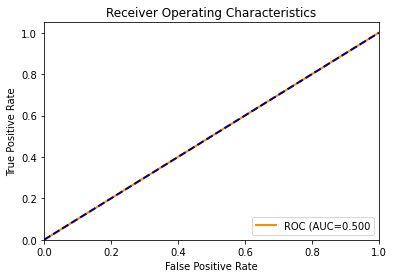

In [24]:
# Generate actuals
act = np.array(data['TARGET_5Yrs'])
# print("Actual proportions: {}".format(get_list_proportions(act)))

# Generate baseline, based on random re-sampling with the same proportions
random.seed(123)
bas = random.choices([1,0], weights=list(get_list_proportions(act)), k=len(data))
# print("Baseline proportions: {}".format(get_list_proportions(bas)))

# Check objects
# from src.utils.objects import check_object
# check_object(act, "act", _head_size=20)
# check_object(bas, "bas", _head_size=20)

# Check performance
save_reg_perf(bas, act, "Raw baseline", print_matrix=True, print_plot=True, print_dataframe=False)

### Attempt #1: ElasticNet

targ      
          0     1
pred 0   25   355
     1   22  1998

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379


['../../models/Chris/01_LogisticRegression_Defaults.joblib']

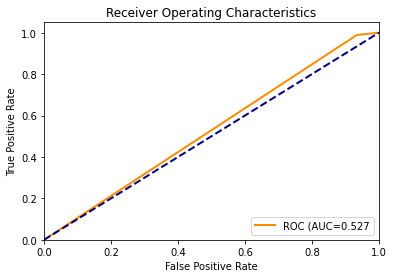

In [25]:
# Import model
from sklearn.linear_model import LogisticRegression

# Instantiate
reg = LogisticRegression(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "LogisticRegression - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "LogisticRegression - Defaults")

# Backup
dump(reg, "../../models/Chris/01_LogisticRegression_Defaults.joblib")

In [26]:
# Marginally better... barely worth it...

### Attempt #2: ElasticNetCV

targ      
          0     1
pred 0   49  1282
     1   38  6631

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948


['../../models/Chris/02_LogisticRegressionCV_Defaults.joblib']

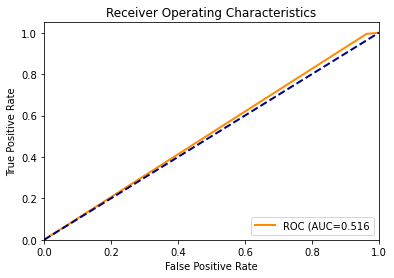

In [27]:
# Import model
from sklearn.linear_model import LogisticRegressionCV

# Instantiate
reg = LogisticRegressionCV(random_state=123)

# Train
reg.fit(feat, targ)

# Predict on validation data
pred = reg.predict(feat)

# Check performance
save_reg_perf(pred, targ, "LogisticRegressionCV - Defaults")

# Backup
dump(reg, "../../models/Chris/02_LogisticRegressionCV_Defaults.joblib")

In [28]:
# Slignt improvement. But nothing substantive yet.

### Attempt #3: RidgeClassifier

targ      
          0     1
pred 0    1   379
     1    3  2017

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350


['../../models/Chris/03_RidgeClassifier_Defaults.joblib']

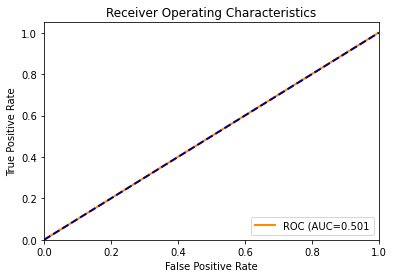

In [29]:
# Import model
from sklearn.linear_model import RidgeClassifier

# Instantiate
reg = RidgeClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RidgeClassifier - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "RidgeClassifier - Defaults")

# Backup
dump(reg, "../../models/Chris/03_RidgeClassifier_Defaults.joblib")

In [30]:
#

### Attempt #4: RidgeClassifierCV

targ      
          0     1
pred 0    5  1326
     1    2  6667

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943


['../../models/Chris/04_RidgeClassifierCV_Defaults.joblib']

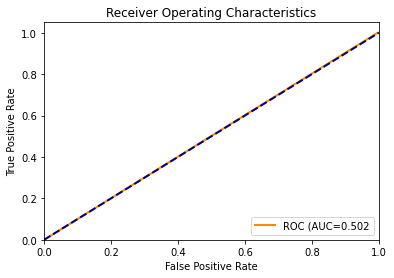

In [31]:
# Import model
from sklearn.linear_model import RidgeClassifierCV

# Instantiate
reg = RidgeClassifierCV(random_state=123)

# Train
reg.fit(feat, targ)

# Predict on validation data
pred = reg.predict(feat)

# Check performance
save_reg_perf(pred, targ, "RidgeClassifierCV - Defaults")

# Backup
dump(reg, "../../models/Chris/04_RidgeClassifierCV_Defaults.joblib")

### Attempt #5: SGDClassifier

targ      
          0     1
pred 0    0   380
     1    0  2020

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403


['../../models/Chris/05_SGDClassifier_Defaults.joblib']

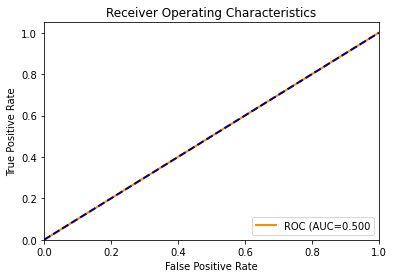

In [32]:
# Import model
from sklearn.linear_model import SGDClassifier

# Instantiate
reg = SGDClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "SGDClassifier - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "SGDClassifier - Defaults")

# Backup
dump(reg, "../../models/Chris/05_SGDClassifier_Defaults.joblib")

### Attempt #6: RandomForest

targ      
          0     1
pred 0   21   359
     1   27  1993

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403
6,RandomForest - Defaults,31/Jan 14:34,0.52095,0.98663,0.05526,0.91171


['../../models/Chris/06_RandomForest_Defaults.joblib']

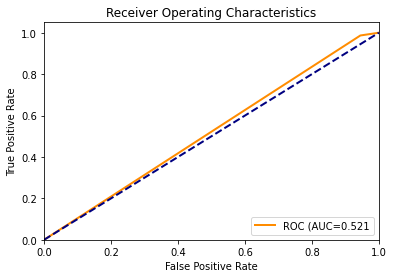

In [33]:
# Import model
from sklearn.ensemble import RandomForestClassifier

# Instantiate
reg = RandomForestClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "RandomForest - Defaults")

# Backup
dump(reg, "../../models/Chris/06_RandomForest_Defaults.joblib")

In [34]:
# **NOW** We're cookin with Gas!

### Attempt #7: Bagging

targ      
          0     1
pred 0   50   330
     1  166  1854

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403
6,RandomForest - Defaults,31/Jan 14:34,0.52095,0.98663,0.05526,0.91171
7,Bagging - Defaults,31/Jan 14:34,0.52470,0.91782,0.13158,0.88202


['../../models/Chris/07_Bagging_Defaults.joblib']

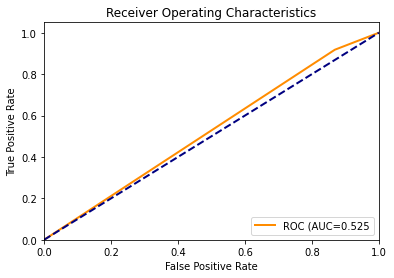

In [35]:
# Import model
from sklearn.ensemble import BaggingClassifier

# Instantiate
reg = BaggingClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "Bagging - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "Bagging - Defaults")

# Backup
dump(reg, "../../models/Chris/07_Bagging_Defaults.joblib")

### Attempt #8: Gradient Boosting

targ      
          0     1
pred 0   20   360
     1   42  1978

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403
6,RandomForest - Defaults,31/Jan 14:34,0.52095,0.98663,0.05526,0.91171
7,Bagging - Defaults,31/Jan 14:34,0.52470,0.91782,0.13158,0.88202
8,Boosting - Defaults,31/Jan 14:35,0.51592,0.97921,0.05263,0.90776


['../../models/Chris/08_Boosting_Defaults.joblib']

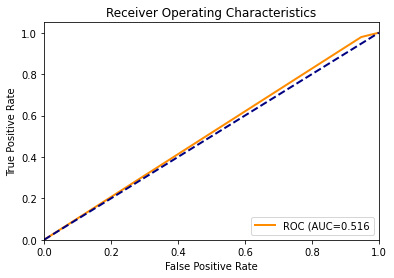

In [36]:
# Import model
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate
reg = GradientBoostingClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "Boosting - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "Boosting - Defaults")

# Backup
dump(reg, "../../models/Chris/08_Boosting_Defaults.joblib")

In [37]:
# Slightly better than the ElasticNet models, not as good as the RandomForest

### Attempt #9: AdaBoost

targ      
          0     1
pred 0   23   357
     1   49  1971

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403
6,RandomForest - Defaults,31/Jan 14:34,0.52095,0.98663,0.05526,0.91171
7,Bagging - Defaults,31/Jan 14:34,0.52470,0.91782,0.13158,0.88202
8,Boosting - Defaults,31/Jan 14:35,0.51592,0.97921,0.05263,0.90776
9,AdaBoost - Defaults,31/Jan 14:35,0.51813,0.97574,0.06053,0.90662


['../../models/Chris/09_AdaBoost_Defaults.joblib']

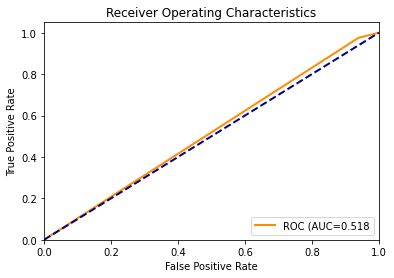

In [38]:
# Import model
from sklearn.ensemble import AdaBoostClassifier

# Instantiate
reg = AdaBoostClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "AdaBoost - Defaults - within bag", print=False)
save_reg_perf(pred_val, targ_val, "AdaBoost - Defaults")

# Backup
dump(reg, "../../models/Chris/09_AdaBoost_Defaults.joblib")

### Attempt #10: LogisticRegression - RandomSearch

In [46]:
print(get_list_proportions(targ))

{0: 0.166375, 1: 0.833625}


{'C': 2.8778758791422523, 'penalty': 'l2', 'solver': 'lbfgs'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc,split0_train_auc,split1_train_auc,split2_train_auc,split3_train_auc,split4_train_auc,mean_train_auc,std_train_auc
0,0.000600,0.000801,0.000000,0.000000,2.785877,elasticnet,lbfgs,"{'C': 2.7858767423914466, 'penalty': 'elasticn...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000200,0.000400,0.000000,0.000000,0.907406,elasticnet,saga,"{'C': 0.9074058142568124, 'penalty': 'elasticn...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.063000,0.004604,0.001200,0.000399,2.877876,l2,lbfgs,"{'C': 2.8778758791422523, 'penalty': 'l2', 'so...",0.5,0.5,0.5,0.50188,0.5,0.500376,0.000752,1,0.500939,0.5,0.500939,0.500469,0.5,0.500469,0.000420
3,0.062201,0.004580,0.001605,0.000496,1.643697,l2,lbfgs,"{'C': 1.6436974908360757, 'penalty': 'l2', 'so...",0.5,0.5,0.5,0.50188,0.5,0.500376,0.000752,1,0.500939,0.5,0.500939,0.500469,0.5,0.500469,0.000420
4,0.001010,0.000029,0.000000,0.000000,0.559803,l1,lbfgs,"{'C': 0.5598030505215381, 'penalty': 'l1', 'so...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,3.984345,elasticnet,saga,"{'C': 3.9843453094713017, 'penalty': 'elasticn...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,1.737806,0.029565,0.001804,0.000404,2.295096,l2,saga,"{'C': 2.295096454635298, 'penalty': 'l2', 'sol...",0.5,0.5,0.5,0.50188,0.5,0.500376,0.000752,1,0.500939,0.5,0.500939,0.500469,0.5,0.500469,0.000420
97,1.729825,0.040439,0.001991,0.000010,2.799336,l2,saga,"{'C': 2.799336299091659, 'penalty': 'l2', 'sol...",0.5,0.5,0.5,0.50188,0.5,0.500376,0.000752,1,0.500939,0.5,0.500939,0.500469,0.5,0.500469,0.000420
98,0.388189,0.042681,0.001401,0.000477,0.196389,l2,saga,"{'C': 0.19638852249110528, 'penalty': 'l2', 's...",0.5,0.5,0.5,0.50188,0.5,0.500376,0.000752,1,0.500939,0.5,0.500469,0.500469,0.5,0.500376,0.000351


targ      
          0     1
pred 0    2  1329
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403
6,RandomForest - Defaults,31/Jan 14:34,0.52095,0.98663,0.05526,0.91171
7,Bagging - Defaults,31/Jan 14:34,0.52470,0.91782,0.13158,0.88202
8,Boosting - Defaults,31/Jan 14:35,0.51592,0.97921,0.05263,0.90776
9,AdaBoost - Defaults,31/Jan 14:35,0.51813,0.97574,0.06053,0.90662


['../../models/Chris/10_LogisticRegression_RandomSearch.joblib']

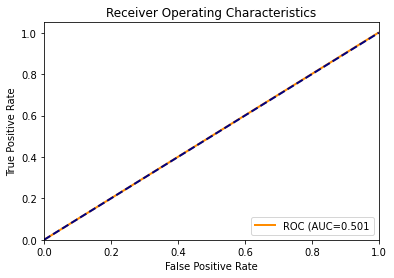

In [60]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from scipy.stats import uniform

# Instantiate
reg = LogisticRegression \
    ( class_weight=get_list_proportions(targ)
    , random_state=123
    , max_iter=1000
    )

# Define hyperparameters
params = dict \
    ( penalty=['l1', 'l2', 'elasticnet']
    , C=uniform(loc=0, scale=4)
    , solver=['lbfgs', 'saga']
    )

# Re-instantiate
clf = RandomizedSearchCV\
    ( estimator=reg
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
res = clf.fit(feat, targ)

# Check best params
print(res.best_params_)
display(pd.DataFrame(res.cv_results_))

# Predict
pred = clf.predict(feat)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(pred, targ, "LogisticRegression - RandomSearch")

# Backup
dump(reg, "../../models/Chris/10_LogisticRegression_RandomSearch.joblib")

### Attempt 11: RandomForest - RandomSearch

{'bootstrap': True, 'ccp_alpha': 2.1393174541890976, 'max_depth': 100, 'min_impurity_decrease': 0.4247158970388948, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.4172099480253376, 'n_estimators': 313, 'oob_score': True}


targ      
          0     1
pred 0    0  1331
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,31/Jan 14:34,0.50000,0.00000,1.00000,0.00000
1,LogisticRegression - Defaults,31/Jan 14:34,0.52745,0.98911,0.06579,0.91379
2,LogisticRegressionCV - Defaults,31/Jan 14:34,0.51556,0.99430,0.03681,0.90948
3,RidgeClassifier - Defaults,31/Jan 14:34,0.50057,0.99851,0.00263,0.91350
4,RidgeClassifierCV - Defaults,31/Jan 14:34,0.50173,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,31/Jan 14:34,0.50000,1.00000,0.00000,0.91403
6,RandomForest - Defaults,31/Jan 14:34,0.52095,0.98663,0.05526,0.91171
7,Bagging - Defaults,31/Jan 14:34,0.52470,0.91782,0.13158,0.88202
8,Boosting - Defaults,31/Jan 14:35,0.51592,0.97921,0.05263,0.90776
9,AdaBoost - Defaults,31/Jan 14:35,0.51813,0.97574,0.06053,0.90662


['../../models/Chris/11_RandomForest_RandomSearch.joblib']

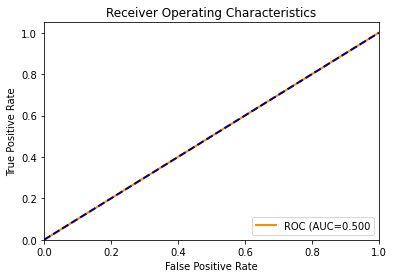

In [63]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

# Instantiate
reg = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ)
    )

# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=100, high=500)
    , max_depth=[5,10,20,50,75,100,200]
    , min_samples_split=randint(low=1, high=10)
    , min_samples_leaf=randint(low=1, high=10)
    , min_weight_fraction_leaf=uniform(loc=0, scale=1)
    , min_impurity_decrease=uniform(loc=0, scale=0.5)
    , bootstrap=[True,False]
    , oob_score=[True,False]
    , ccp_alpha=uniform(loc=0, scale=5)
    )

# Re-instantiate
clf = RandomizedSearchCV\
    ( estimator=reg
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
res = clf.fit(feat, targ)

# Check best params
print(res.best_params_)

# Predict
pred = clf.predict(feat)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(pred, targ, "RandomForest - RandomSearch")

# Backup
dump(reg, "../../models/Chris/11_RandomForest_RandomSearch.joblib")

## Final Processing & Submitting

### Define final processing steps

In [40]:
def final_prediction_processing \
    ( final_model_path:str
    , data_scaler_path:str
    , test_data_path:str="../../data/raw/test.csv"
    , submission_data_path:str="../../data/external/final.csv"
    , check:bool=False
    ):
    """
    Process the data for the final prediction.
    Note, this will update the prediction and save it to the `submission_data_path` location.

    Args:
        final_model_path (str): The location from which the final model should be drawn from. Note, this model should be saved as a `` file type, and once imported, should be a sklearn model class.
        data_scaler_path (str): The location from which the data scaler should be imported from. Note, this should be a sklearn preprocessing class
        test_data_path (str, optional): The location from which the test data should be imported. Note, it should be a `.csv` file type. Defaults to "../../data/raw/test.csv".
        submission_data_path (str, optional): The location to which the final submission data should be stored. Note, it should be a `.csv` file type. Defaults to "../../data/external/final.csv".
        check (bool, optional): Optional flag for wheather or not to `display()` the final data frame, mainly for checking purposes. Defaults to False.

    Returns:
        pd.DataFrame: The updated `submission_data` dataframe
    """

    # Imports
    import numpy as np
    import pandas as pd

    # Assertions
    for parameter in [final_model_path, data_scaler_path, test_data_path, submission_data_path]:
        assert np.isscalar(parameter)
        assert isinstance(parameter, str)
        if parameter in [final_model_path, data_scaler_path]:
            assert str_right(parameter, 7) == ".joblib"
        if parameter in [test_data_path, submission_data_path]:
            assert str_right(parameter, 4) == ".csv"
    assert isinstance(check, bool)
    
    # Import selected data
    final_model = load(final_model_path)
    data_scaler = load(data_scaler_path)
    test_data = pd.read_csv(test_data_path)

    # Process final data
    submission_data = test_data.pop("Id")
    test_data = data_scaler.fit_transform(test_data)

    # Get prediction
    final_prediction = final_model.predict(test_data)

    # Form final data
    submission_data = pd.concat([pd.DataFrame(submission_data), pd.DataFrame(final_prediction)], axis=1)
    submission_data.columns = ["Id", "TARGET_5Yrs"]
    submission_data["TARGET_5Yrs"] = submission_data["TARGET_5Yrs"].apply(lambda pred: 1 if pred > 0.5 else 0)

    # Check
    if check:
        display(submission_data)

    # Save to file
    submission_data.to_csv(submission_data_path, index=False)

    return submission_data

In [41]:
# Process the final data
submission_data = final_prediction_processing \
    ( final_model_path = "../../models/Chris/07_Bagging_Defaults.joblib"
    , data_scaler_path = "../../models/Chris/scaler.joblib"
    , test_data_path = "../../data/raw/test.csv"
    , submission_data_path = "../../data/external/final.csv"
    )

### Submit to Kaggle

In [42]:
# Function to call Kaggle API
def call_kaggle_api(upload_file, upload_message):
    """
    Call the Kaggle API to submit a file
    Inspiration: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script#answer-579917
    
    Args:
        upload_file (str): The source path where the file will be uploaded _from_.
        upload_message (str): The message that will be sent to Kaggle for this submission.

    Raises:
        Exception: CallProcessError, incase subprocess has a wobbly
        Exception: Exception, for everything else

    Returns:
        str: The confirmation string from the API call
    """

    import subprocess

    bash_call = "kaggle competitions submit --competition uts-advdsi-nba-career-prediction --file {upload_file} --message {upload_message} --quiet".format(upload_file=upload_file, upload_message=upload_message)

    try:        
        result = subprocess.run(bash_call, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as err:
        raise Exception(str(err.stderr.decode("utf-8")))
    except Exception as err:
        raise Exception(err)
    else:
        return result.stdout.decode("utf-8")

In [44]:
# Call the API
if True:
    call_kaggle_api \
        ( upload_file = "../../data/external/final.csv"
        , upload_message = "Ctrl-Alt-Elite_RandomForest_Defaults"
        )